<a href="https://colab.research.google.com/github/ArthurHSM/Big_Data_Real-Time_Analytics_With_Python_and_Spark/blob/main/Analise_Risco_Transporte_Public_Londres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.12


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4a39bb326a10b637b0e93efb009c7727cdd401758810e7027970e7ded8f3c28f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# https://pypi.org/project/findspark/ac
!pip install -q findspark

In [ ]:
# https://pypi.org/project/pandasql/
!pip install -q pandasql

  Preparing metadata (setup.py) ... done


In [ ]:
# Imports
import psycopg2
import pandasql
import sqlalchemy
import pandas as pd
from pandasql import sqldf
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# caminho para leitura do arquivo no google drive
# Instalar as bibliotecas necessárias
!pip install pandas openpyxl gdown pyspark

# Baixar o arquivo do Google Drive
import gdown

file_id = '1_Fk1ra_UfRAmemyk0IERtnHXmldch3nK'  # substitua pelo seu ID do arquivo
download_url = f"https://drive.google.com/uc?id={file_id}"
output = 'file.xlsx'
gdown.download(download_url, output, quiet=False)

# Ler o arquivo Excel com pandas
import pandas as pd

df = pd.read_excel('file.xlsx')

# Configurar PySpark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('Google Colab PySpark') \
    .getOrCreate()

# Converter o DataFrame pandas para um DataFrame PySpark
df_spark = spark.createDataFrame(df)


Downloading...
From: https://drive.google.com/uc?id=1_Fk1ra_UfRAmemyk0IERtnHXmldch3nK
To: /content/file.xlsx
100%|██████████| 1.25M/1.25M [00:00<00:00, 110MB/s]


In [ ]:
# dataframe spark
df_spark.show()

+----+-------------------+-----+--------------+-------------+--------------------+--------------------+-------------------------+-------------------+---------------+-----------+-----------+
|Year|   Date Of Incident|Route|      Operator|   Group Name|          Bus Garage|             Borough|Injury Result Description|Incident Event Type|Victim Category|Victims Sex|Victims Age|
+----+-------------------+-----+--------------+-------------+--------------------+--------------------+-------------------------+-------------------+---------------+-----------+-----------+
|2015|2015-01-01 00:00:00|    1|London General|     Go-Ahead|Garage Not Available|           Southwark|     Injuries treated ...|   Onboard Injuries|      Passenger|       Male|      Child|
|2015|2015-01-01 00:00:00|    4|     Metroline|    Metroline|Garage Not Available|           Islington|     Injuries treated ...|   Onboard Injuries|      Passenger|       Male|    Unknown|
|2015|2015-01-01 00:00:00|    5|   East London|   

# Question 01 - Qual a quantidade de incidentes por gênero?

In [ ]:
# agrupando valores para entender sua distribuição
df_spark.groupBy('Victims Sex').count().show()

+-----------+-----+
|Victims Sex|count|
+-----------+-----+
|     Female|11847|
|    Unknown| 3602|
|       Male| 7709|
+-----------+-----+



In [ ]:
# agrupando valores para entender sua distribuição
df_spark.groupBy('Year').count().show()

+----+-----+
|Year|count|
+----+-----+
|2016| 6093|
|2015| 5715|
|2018| 4777|
|2017| 6573|
+----+-----+



In [ ]:
# contrução de um dataframe auxiliar para plotar o grafico
df_1 = df_spark.groupBy('Year')\
               .agg(
                      F.count(F.when(F.col('Victims Sex') == 'Male', F.col('Victims Sex'))).alias('Male Incidents'),
                      F.count(F.when(F.col('Victims Sex') == 'Female', F.col('Victims Sex'))).alias('Female Incidents'),
                      F.count(F.when(F.col('Victims Sex') == 'Unknown', F.col('Victims Sex'))).alias('Unknown Incidents')
               )\
              .withColumn('Total Incidents', F.col('Male Incidents') + F.col('Female Incidents') + F.col('Unknown Incidents'))\
              .withColumn('perc_male', F.round(F.col('Male Incidents') / F.col('Total Incidents'), 2))\
              .withColumn('perc_female', F.round(F.col('Female Incidents') / F.col('Total Incidents'), 2))\
              .withColumn('perc_unknown', F.round(F.col('Unknown Incidents') / F.col('Total Incidents'), 2))
df_1 = df_1.orderBy("Year")
df_1.show()

+----+--------------+----------------+-----------------+---------------+---------+-----------+------------+
|Year|Male Incidents|Female Incidents|Unknown Incidents|Total Incidents|perc_male|perc_female|perc_unknown|
+----+--------------+----------------+-----------------+---------------+---------+-----------+------------+
|2015|          1617|            2259|             1839|           5715|     0.28|        0.4|        0.32|
|2016|          2106|            3327|              660|           6093|     0.35|       0.55|        0.11|
|2017|          2363|            3598|              612|           6573|     0.36|       0.55|        0.09|
|2018|          1623|            2663|              491|           4777|     0.34|       0.56|         0.1|
+----+--------------+----------------+-----------------+---------------+---------+-----------+------------+



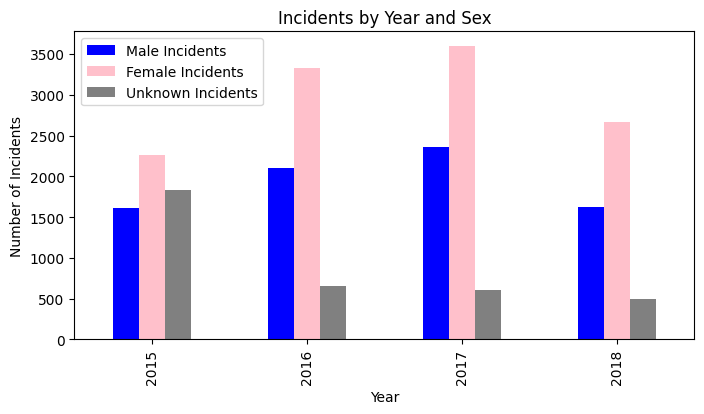

In [ ]:
# conversão para Pandas do df_1_pandas
df_1_pandas = df_1.toPandas()

# tamanho da figura
fig, ax1 = plt.subplots(figsize=(8, 4))

# dados de incidentes como colunas
df_1_pandas.plot(kind='bar', x='Year', y=['Male Incidents', 'Female Incidents', 'Unknown Incidents'], ax=ax1, color=['blue', 'pink', 'gray'])
ax1.set_ylabel('Number of Incidents')
ax1.set_title('Incidents by Year and Sex')
ax1.set_xlabel('Year')

# Ajuste a legenda
ax1.legend(loc='upper left')

# plot
plt.show()

# Question 02 - Qual faixa etária esteve mais envolvida nos incidentes?

In [ ]:
df_spark.groupBy('Victims Age').count().show()

+-----------+-----+
|Victims Age|count|
+-----------+-----+
|    Unknown| 7135|
|      Youth|  319|
|      Adult|10754|
|      Child| 2181|
|    Elderly| 2769|
+-----------+-----+



In [ ]:
df_2 = df_spark.groupBy('Victims Age').count().withColumnRenamed('count', 'Total_Incidents_by_Age')
df_2 = df_2.orderBy('Victims Age')
df_2.show()

+-----------+----------------------+
|Victims Age|Total_Incidents_by_Age|
+-----------+----------------------+
|      Adult|                 10754|
|      Child|                  2181|
|    Elderly|                  2769|
|    Unknown|                  7135|
|      Youth|                   319|
+-----------+----------------------+



<Figure size 800x400 with 0 Axes>

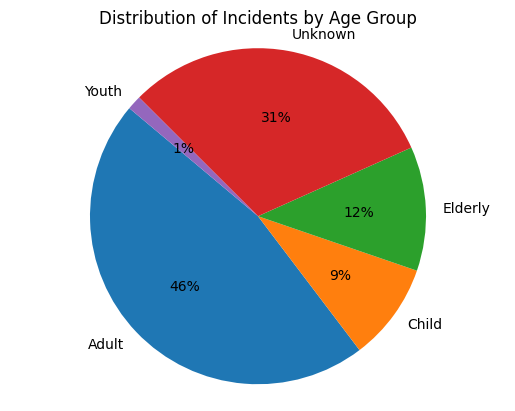

In [ ]:
# conversão para Pandas do df_2_pandas
df_2_pandas = df_2.toPandas()

# tamanho da figura
plt.figure(figsize=(8, 4))

# dados de incidentes como pizza
df_2_pandas.plot(kind='pie', y='Total_Incidents_by_Age', labels=df_2_pandas['Victims Age'], autopct='%1.0f%%', startangle=140, legend=False)

# título
plt.title('Distribution of Incidents by Age Group')

# Removendo rótulo do eixo Y (vertical)
plt.ylabel('')

# plot
plt.axis('equal')
plt.show()

# Question 03 - Qual o percentual de incidentes por tipo de evento?

In [ ]:
df_spark.groupBy('Incident Event Type').count().show()

+--------------------+-----+
| Incident Event Type|count|
+--------------------+-----+
|Vandalism Hooliga...|   73|
|     Personal Injury| 4596|
|             Assault|  590|
|             Robbery|    3|
|    Onboard Injuries| 6563|
|  Collision Incident| 4166|
|Activity Incident...|  114|
|                Fire|    6|
|      Slip Trip Fall| 6981|
|Safety Critical F...|   66|
+--------------------+-----+



In [ ]:
df_3 = df_spark.groupBy('Incident Event Type').count().withColumnRenamed('count', 'Total_Incidents_by_Event_Type')
df_3 = df_3.orderBy('Incident Event Type')
df_3.show()

+--------------------+-----------------------------+
| Incident Event Type|Total_Incidents_by_Event_Type|
+--------------------+-----------------------------+
|Activity Incident...|                          114|
|             Assault|                          590|
|  Collision Incident|                         4166|
|                Fire|                            6|
|    Onboard Injuries|                         6563|
|     Personal Injury|                         4596|
|             Robbery|                            3|
|Safety Critical F...|                           66|
|      Slip Trip Fall|                         6981|
|Vandalism Hooliga...|                           73|
+--------------------+-----------------------------+



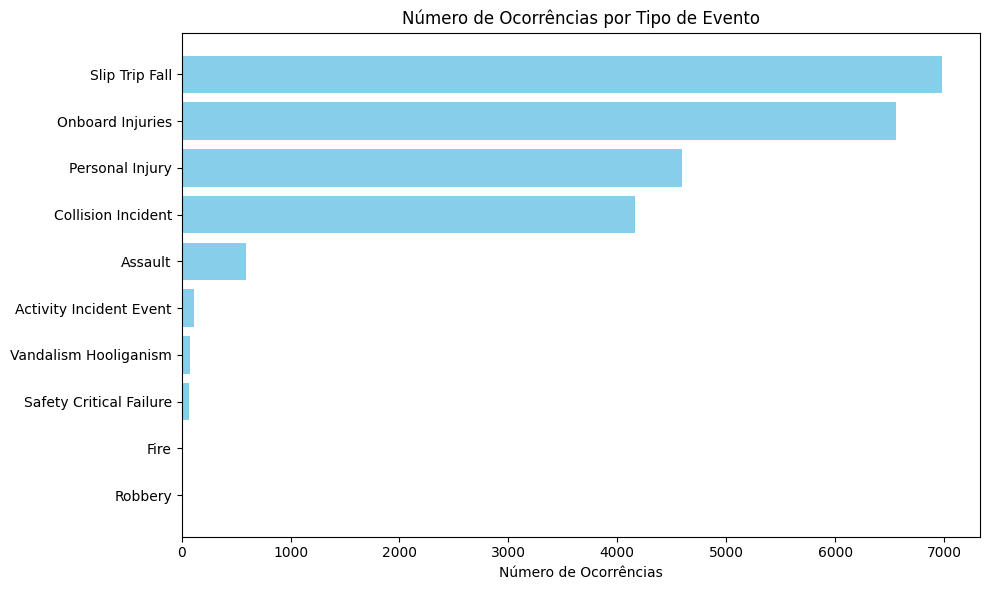

In [ ]:
# Convertendo DataFrame Spark para pandas DataFrame
df_3_pandas = df_3.toPandas()

# Ordenando o DataFrame pandas pelo número de ocorrências (count)
df_3_pandas = df_3_pandas.sort_values(by='Total_Incidents_by_Event_Type', ascending=True)

# Configurando o tamanho do gráfico
plt.figure(figsize=(10, 6))

# Plotando o gráfico de barras horizontais
plt.barh(df_3_pandas['Incident Event Type'], df_3_pandas['Total_Incidents_by_Event_Type'], color='skyblue')

# Adicionando rótulos e título
plt.xlabel('Número de Ocorrências')
plt.ylabel('Tipo de Evento')
plt.title('Número de Ocorrências por Tipo de Evento')

# Removendo rótulo do eixo Y (vertical)
plt.ylabel('')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

# Question 04 - Como foi a evolução de incidentes por mês ao longo do tempo?

In [ ]:
# analisando a distribuição dos valores da coluna para criar outra coluna mes
df_spark.groupBy('Date Of Incident').count().show()

+-------------------+-----+
|   Date Of Incident|count|
+-------------------+-----+
|2016-02-01 00:00:00|  484|
|2015-02-01 00:00:00|  371|
|2016-04-01 00:00:00|  504|
|2016-08-01 00:00:00|  513|
|2016-06-01 00:00:00|  460|
|2015-07-01 00:00:00|  558|
|2016-11-01 00:00:00|  612|
|2016-12-01 00:00:00|  471|
|2015-09-01 00:00:00|  487|
|2016-09-01 00:00:00|  582|
|2015-10-01 00:00:00|  470|
|2015-12-01 00:00:00|  523|
|2015-01-01 00:00:00|  399|
|2015-04-01 00:00:00|  470|
|2015-06-01 00:00:00|  564|
|2016-05-01 00:00:00|  494|
|2015-05-01 00:00:00|  472|
|2016-07-01 00:00:00|  507|
|2015-11-01 00:00:00|  495|
|2016-10-01 00:00:00|  551|
+-------------------+-----+
only showing top 20 rows



In [ ]:
# criando coluna mês
df_4 = df_spark.withColumn('Month', F.month('Date Of Incident'))

# concatenando com o ano
df_4 = df_4.withColumn('Month_Year', F.concat(F.col('Year'), F.lit('_'), F.col('Month')))

# agrupando por mes a quantidade de incidentes
df_4 = df_4.groupBy('Month_Year', 'Year', 'Month').count().withColumnRenamed('count', 'Total_Incidents_by_Month')
df_4 = df_4.orderBy('Year', 'Month')
df_4.show()

+----------+----+-----+------------------------+
|Month_Year|Year|Month|Total_Incidents_by_Month|
+----------+----+-----+------------------------+
|    2015_1|2015|    1|                     399|
|    2015_2|2015|    2|                     371|
|    2015_3|2015|    3|                     460|
|    2015_4|2015|    4|                     470|
|    2015_5|2015|    5|                     472|
|    2015_6|2015|    6|                     564|
|    2015_7|2015|    7|                     558|
|    2015_8|2015|    8|                     446|
|    2015_9|2015|    9|                     487|
|   2015_10|2015|   10|                     470|
|   2015_11|2015|   11|                     495|
|   2015_12|2015|   12|                     523|
|    2016_1|2016|    1|                     466|
|    2016_2|2016|    2|                     484|
|    2016_3|2016|    3|                     449|
|    2016_4|2016|    4|                     504|
|    2016_5|2016|    5|                     494|
|    2016_6|2016|   

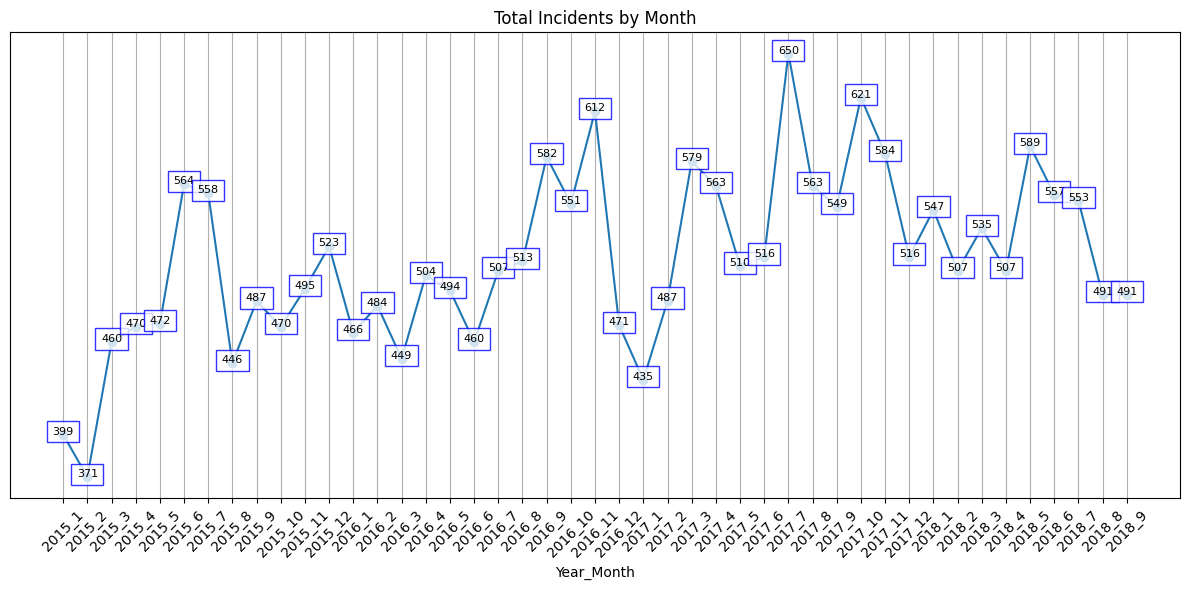

In [ ]:
# conversão para Pandas do df_4_pandas
df_4_pandas = df_4.toPandas()

# Grafico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_4_pandas['Month_Year'], df_4_pandas['Total_Incidents_by_Month'], marker='o')

# Data Labels
for x, y in zip(df_4_pandas['Month_Year'], df_4_pandas['Total_Incidents_by_Month']):
    plt.text(x, y, str(y), fontsize=8, ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'))

# Ocultando o eixo Y
plt.gca().axes.yaxis.set_visible(False)

plt.title('Total Incidents by Month')
plt.xlabel('Year_Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Question 05 - Quando o incidente foi “Collision Incident” em qual mês houve o maior número de incidentes envolvendo pessoas do sexo feminino?

In [ ]:
# Incident Event Type
# Collision Incident

# Filtrando condições da pergunta
df_5 = df_spark.filter((F.col('Incident Event Type') == 'Collision Incident') &
                       (F.col('Victims Sex') == 'Female'))\
               .withColumn('Month', F.month('Date Of Incident'))\
               .withColumn('Year_Month', F.concat(F.col('Year'), F.lit('_'), F.col('Month')))\
               .orderBy('Year', 'Month')

df_5 = df_5.groupBy('Year_Month', 'Year', 'Month').count().withColumnRenamed('count', 'Total_Female_Collision_Incidents')
df_5 = df_5.orderBy('Year', 'Month')
df_5.show()

+----------+----+-----+--------------------------------+
|Year_Month|Year|Month|Total_Female_Collision_Incidents|
+----------+----+-----+--------------------------------+
|    2015_1|2015|    1|                              16|
|    2015_2|2015|    2|                              25|
|    2015_3|2015|    3|                              26|
|    2015_4|2015|    4|                              38|
|    2015_5|2015|    5|                              26|
|    2015_6|2015|    6|                              43|
|    2015_7|2015|    7|                              32|
|    2015_8|2015|    8|                              20|
|    2015_9|2015|    9|                              45|
|   2015_10|2015|   10|                              28|
|   2015_11|2015|   11|                              30|
|   2015_12|2015|   12|                              26|
|    2016_1|2016|    1|                              35|
|    2016_2|2016|    2|                              23|
|    2016_3|2016|    3|        

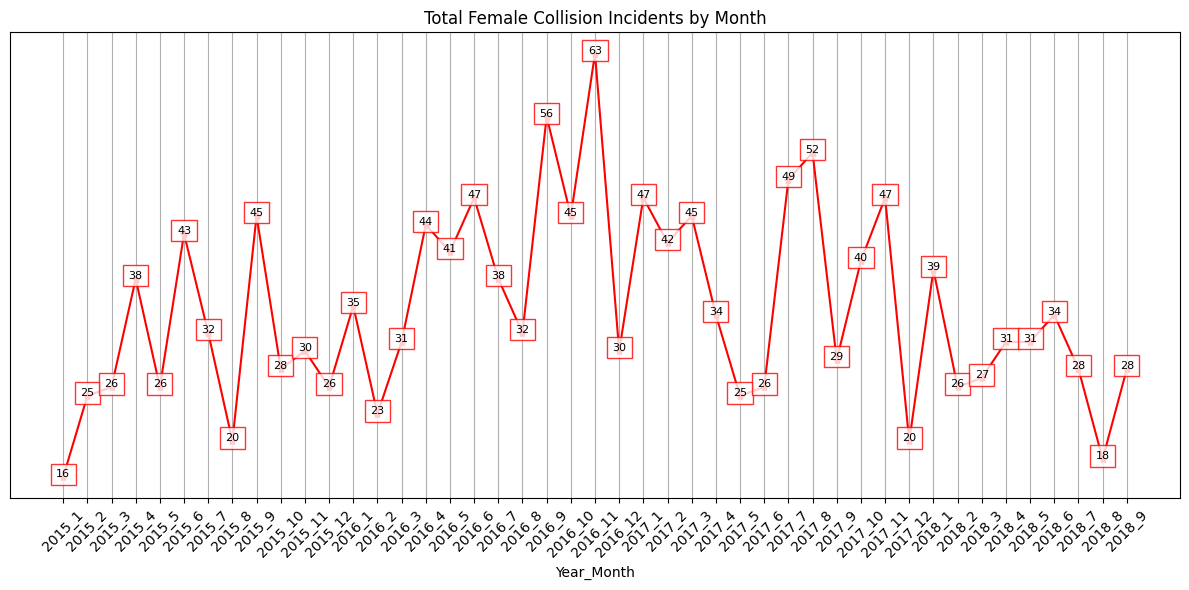

In [ ]:
# conversão para Pandas do df_5_pandas
df_5_pandas = df_5.toPandas()

# Grafico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_5_pandas['Year_Month'], df_5_pandas['Total_Female_Collision_Incidents'], marker='*', color='red')

# Data Labels
for x, y in zip(df_5_pandas['Year_Month'], df_5_pandas['Total_Female_Collision_Incidents']):
    plt.text(x, y, str(y), fontsize=8, ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

# Ocultando o eixo Y
plt.gca().axes.yaxis.set_visible(False)

plt.title('Total Female Collision Incidents by Month')
plt.xlabel('Year_Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Outubro de 2016 foi o mes com mais ocorrencias de colisões envolvendo pessoas do sexo feminino

# Question 06 - Qual foi a média de incidentes por mês envolvendo crianças (Child)?

In [ ]:
df_aux = df_spark.withColumn('Month', F.month('Date Of Incident'))\
                 .withColumn('Year_Month', F.concat(F.col('Year'), F.lit('_'), F.col('Month')))\
                 .orderBy('Year', 'Month')

df_6_aux = df_aux.groupBy('Year_Month', 'Year', 'Month')\
           .agg(
                F.count(F.when(F.col('Victims Age') == 'Child', F.col('Year'))).alias('Tt_Child_Incidents')
               )
df_6_aux = df_6_aux.orderBy('Year', 'Month')


df_6 = df_6_aux.groupBy('Month')\
               .agg(
                   F.round(F.avg(F.col('Tt_Child_Incidents')),0).alias('Avg_Child_Incidents')
               )
df_6 = df_6.orderBy('Month')
df_6 = df_6.withColumn('Name_Month',
                       F.when(F.col('Month') == 1, 'January')\
                        .when(F.col('Month') == 2, 'February')\
                        .when(F.col('Month') == 3, 'March')\
                        .when(F.col('Month') == 4, 'April')\
                        .when(F.col('Month') == 5, 'May')
                        .when(F.col('Month') == 6, 'June')
                        .when(F.col('Month') == 7, 'July')
                        .when(F.col('Month') == 8, 'August')
                        .when(F.col('Month') == 9, 'September')
                        .when(F.col('Month') == 10, 'October')
                        .when(F.col('Month') == 11, 'November')
                        .when(F.col('Month') == 12, 'December'))
df_6 = df_6.select('Name_Month', 'Avg_Child_Incidents')
df_6.show()

+----------+-------------------+
|Name_Month|Avg_Child_Incidents|
+----------+-------------------+
|   January|               32.0|
|  February|               37.0|
|     March|               48.0|
|     April|               57.0|
|       May|               52.0|
|      June|               61.0|
|      July|               58.0|
|    August|               52.0|
| September|               56.0|
|   October|               50.0|
|  November|               40.0|
|  December|               36.0|
+----------+-------------------+



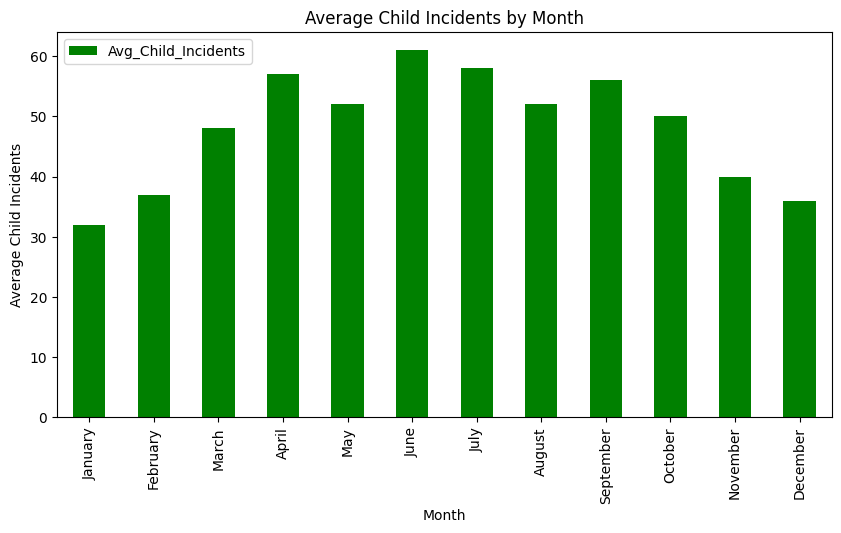

In [ ]:
# conversão para Pandas do df_6_pandas
df_6_pandas = df_6.toPandas()

# tamanho da figura
fig, ax1 = plt.subplots(figsize=(10, 5))

# dados de incidentes como colunas
df_6_pandas.plot(kind='bar', x = 'Name_Month', y = 'Avg_Child_Incidents', ax = ax1, color = 'green')
ax1.set_title('Average Child Incidents by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Child Incidents')

# Ajuste a legenda
ax1.legend(loc = 'upper left')

# plot
plt.show()

# Question 07 - Considerando a descrição de incidente como “Injuries treated on scene” (coluna Injury Result Description), qual o total de incidentes de pessoas do sexo masculino e sexo feminino?

In [ ]:
df_7 = df_spark.filter((F.col('Injury Result Description') == 'Injuries treated on scene') &
                       (F.col('Victims Sex').isin('Male', 'Female')))

df_7 = df_7.groupBy('Injury Result Description', 'Victims Sex').count().withColumnRenamed('count', 'Total_Incidents_by_Sex')
df_7.show()

+-------------------------+-----------+----------------------+
|Injury Result Description|Victims Sex|Total_Incidents_by_Sex|
+-------------------------+-----------+----------------------+
|     Injuries treated ...|       Male|                  5632|
|     Injuries treated ...|     Female|                  8816|
+-------------------------+-----------+----------------------+



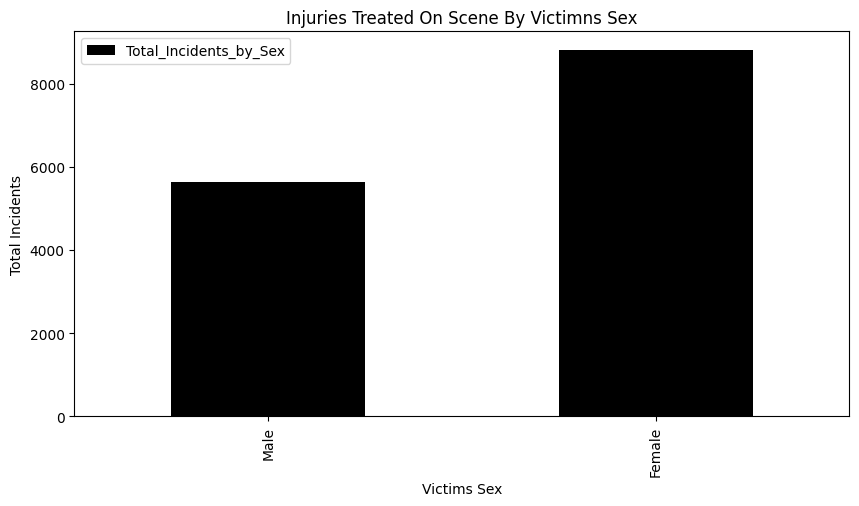

In [ ]:
# conversão para Pandas do df_7_pandas
df_7_pandas = df_7.toPandas()

# tamanho da figura
fig, ax1 = plt.subplots(figsize=(10, 5))

# dados de incidentes como colunas
df_7_pandas.plot(kind='bar', x = 'Victims Sex', y = 'Total_Incidents_by_Sex', ax = ax1, color = 'black')
ax1.set_title('Injuries Treated On Scene By Victimns Sex')
ax1.set_xlabel('Victims Sex')
ax1.set_ylabel('Total Incidents')

# Ajuste a legenda
ax1.legend(loc = 'upper left')

# plot
plt.show()

# Question 08 - No ano de 2017 em qual mês houve mais incidentes com idosos (Elderly)?

In [ ]:
df_8 = df_aux.filter((F.col('Victims Age') == 'Elderly') &
                     (F.col('Year') == 2017))

df_8 = df_8.groupBy('Year_Month', 'Year', 'Month')\
           .agg(
                F.count(F.col('Victims Age')).alias('Total_Elderly_Incidents')
               )
df_8 = df_8.orderBy('Year', 'Month')
df_8.show()

+----------+----+-----+-----------------------+
|Year_Month|Year|Month|Total_Elderly_Incidents|
+----------+----+-----+-----------------------+
|    2017_1|2017|    1|                     66|
|    2017_2|2017|    2|                     53|
|    2017_3|2017|    3|                     77|
|    2017_4|2017|    4|                     75|
|    2017_5|2017|    5|                     69|
|    2017_6|2017|    6|                     65|
|    2017_7|2017|    7|                     81|
|    2017_8|2017|    8|                     70|
|    2017_9|2017|    9|                     78|
|   2017_10|2017|   10|                     69|
|   2017_11|2017|   11|                     68|
|   2017_12|2017|   12|                     67|
+----------+----+-----+-----------------------+



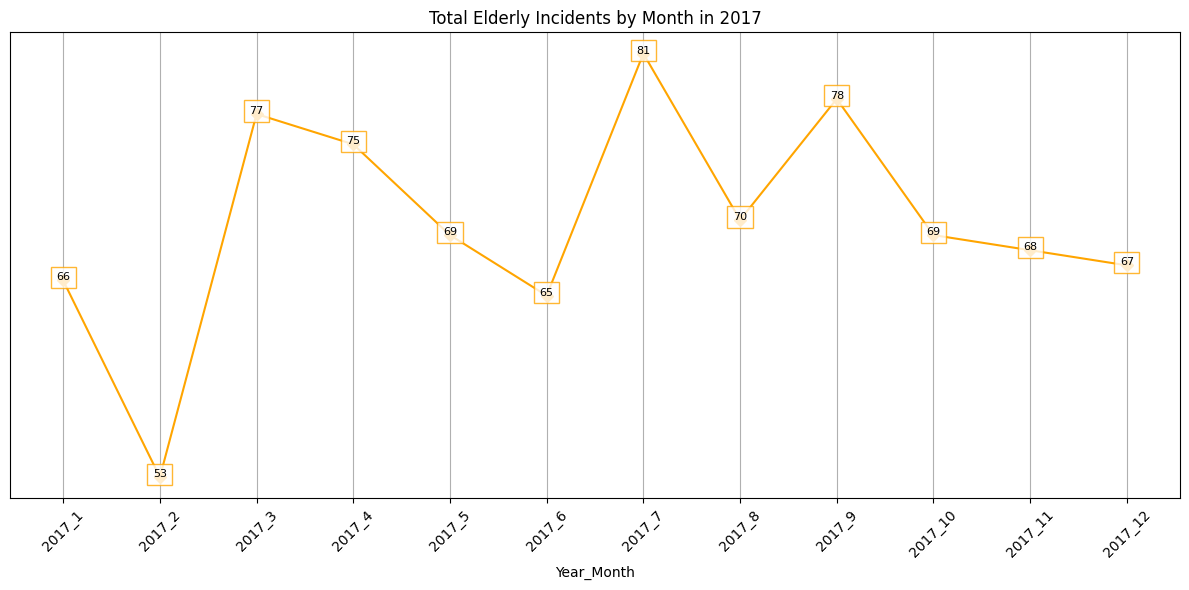

In [ ]:
# conversão para Pandas do df_8_pandas
df_8_pandas = df_8.toPandas()

# Grafico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_8_pandas['Year_Month'], df_8_pandas['Total_Elderly_Incidents'], marker = 'D', color = 'orange')

# Data Labels
for x, y in zip(df_8_pandas['Year_Month'], df_8_pandas['Total_Elderly_Incidents']):
    plt.text(x, y, str(y), fontsize=8, ha='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='orange'))

# Ocultando o eixo Y
plt.gca().axes.yaxis.set_visible(False)

plt.title('Total Elderly Incidents by Month in 2017')
plt.xlabel('Year_Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Julho de 2017 foi o mes com mais incidentes envolvendo pessoas idosas.

# Question 09 - Considerando o Operador qual a distribuição de incidentes ao longo do tempo?

In [ ]:
df_aux.groupBy('Operator').count().show()

+--------------------+-----+
|            Operator|count|
+--------------------+-----+
| Arriva London North| 3208|
|      Metroline West| 1232|
|      London Central| 1367|
|        Abellio West|  126|
|      London General| 1723|
|        H R Richmond|   59|
| Blue Triangle Buses|  281|
|    London Sovereign|  206|
|Arriva Kent Thame...|  107|
|      Sullivan Buses|    2|
|   Arriva The Shires|  305|
|           Metroline| 3457|
|       London United| 2263|
|           TGM GROUP|   61|
|         East London| 2402|
|       Tower Transit|  738|
|      Abellio London|  963|
|     Docklands Buses|  100|
|            C T Plus|   77|
| Arriva London South| 1743|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_9 = df_aux.groupBy('Year_Month', 'Year', 'Month', 'Operator')\
           .agg(
                F.count(F.col('Operator')).alias('Total_Operator_Incidents')
               )
df_9 = df_9.orderBy('Year', 'Month')
df_9.show()

+----------+----+-----+--------------------+------------------------+
|Year_Month|Year|Month|            Operator|Total_Operator_Incidents|
+----------+----+-----+--------------------+------------------------+
|    2015_1|2015|    1|            Metrobus|                      12|
|    2015_1|2015|    1|           Metroline|                      59|
|    2015_1|2015|    1|      London General|                      43|
|    2015_1|2015|    1|         East London|                       4|
|    2015_1|2015|    1|        H R Richmond|                       4|
|    2015_1|2015|    1| Arriva London South|                      27|
|    2015_1|2015|    1|       Tower Transit|                       7|
|    2015_1|2015|    1|     Docklands Buses|                       6|
|    2015_1|2015|    1|        Abellio West|                       1|
|    2015_1|2015|    1|             Selkent|                      27|
|    2015_1|2015|    1|       London United|                      67|
|    2015_1|2015|   

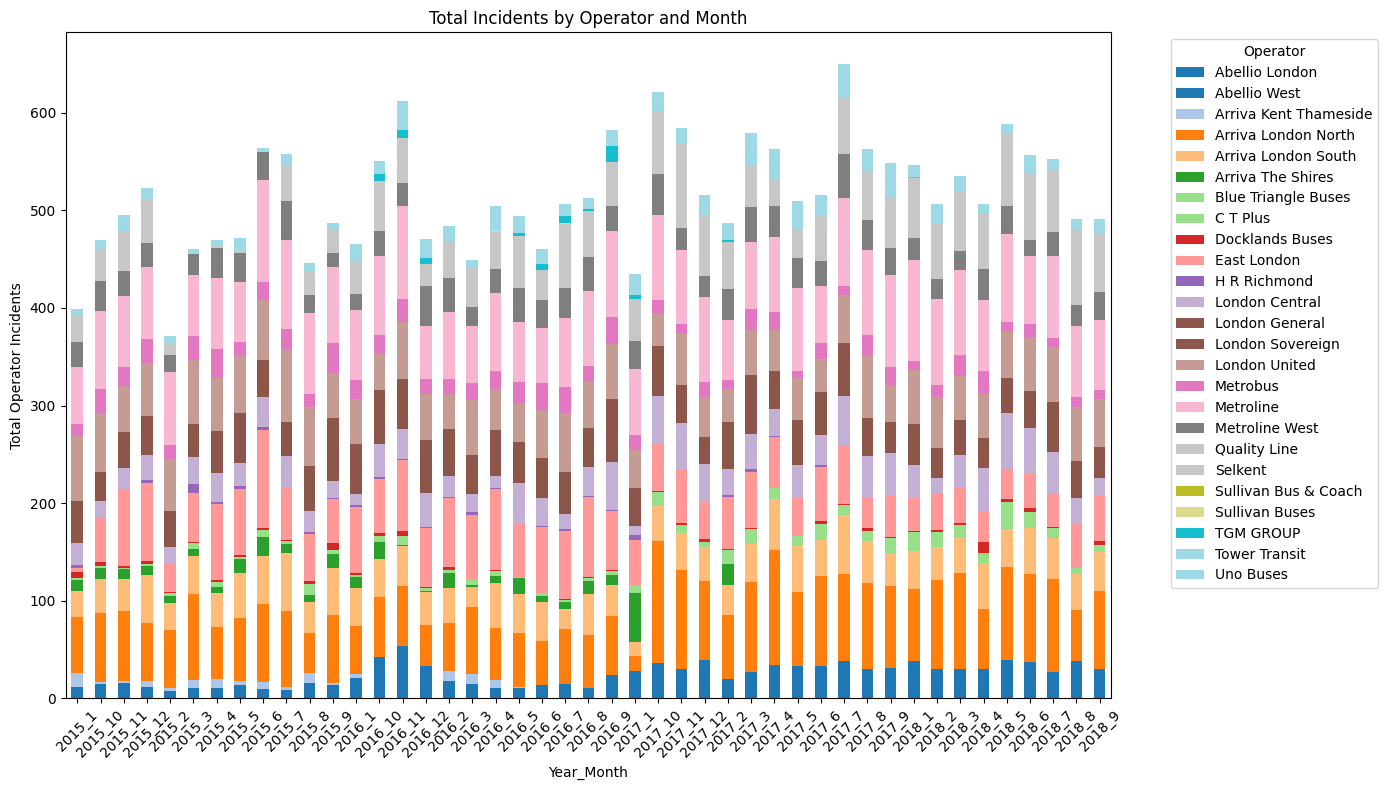

In [ ]:
# conversão para Pandas do df_9_pandas
df_9_pandas = df_9.toPandas()

# Agrupe os dados por 'Year_Month' e 'Operator' e calcule o total de incidentes
grouped_df = df_9_pandas.groupby(['Year_Month', 'Operator'])['Total_Operator_Incidents'].sum().unstack()

# Plote o gráfico de colunas empilhadas
grouped_df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

plt.title('Total Incidents by Operator and Month')
plt.xlabel('Year_Month')
plt.ylabel('Total Operator Incidents')
plt.legend(title='Operator', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# para melhorar a visualização, optei por plotar por Group Name

df_9_2 = df_aux.groupBy('Year_Month', 'Year', 'Month', 'Group Name')\
           .agg(
                F.count(F.col('Operator')).alias('Total_Group_Name_Incidents')
               )
df_9_2 = df_9_2.orderBy('Year', 'Month')
df_9_2.show()

+----------+----+-----+--------------------+--------------------------+
|Year_Month|Year|Month|          Group Name|Total_Group_Name_Incidents|
+----------+----+-----+--------------------+--------------------------+
|    2015_1|2015|    1|          Stagecoach|                        31|
|    2015_1|2015|    1|           Metroline|                        84|
|    2015_1|2015|    1|            Go-Ahead|                        85|
|    2015_1|2015|    1|       Tower Transit|                         7|
|    2015_1|2015|    1|       London United|                        67|
|    2015_1|2015|    1|        Quality Line|                         4|
|    2015_1|2015|    1|Arriva Kent Thame...|                        14|
|    2015_1|2015|    1|             Abellio|                        12|
|    2015_1|2015|    1|   Arriva The Shires|                        11|
|    2015_1|2015|    1|       Arriva London|                        84|
|    2015_2|2015|    2|       Tower Transit|                    

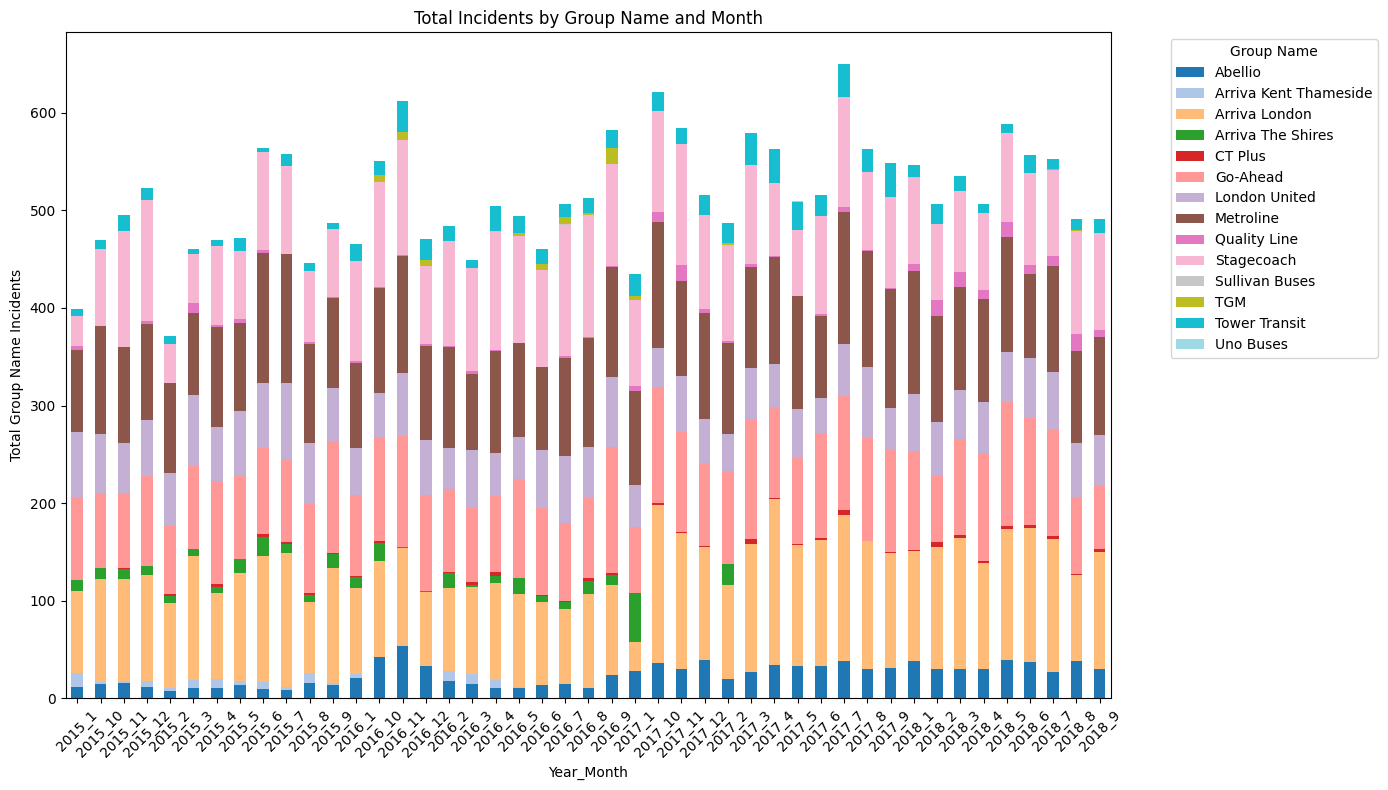

In [ ]:
# conversão para Pandas do df_9_2_pandas
df_9_2_pandas = df_9_2.toPandas()

# Agrupe os dados por 'Year_Month' e 'Operator' e calcule o total de incidentes
grouped_df = df_9_2_pandas.groupby(['Year_Month', 'Group Name'])['Total_Group_Name_Incidents'].sum().unstack()

# Plote o gráfico de colunas empilhadas
grouped_df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

plt.title('Total Incidents by Group Name and Month')
plt.xlabel('Year_Month')
plt.ylabel('Total Group Name Incidents')
plt.legend(title='Group Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Question 10 - Qual o tipo de incidente mais comum com ciclistas?

In [ ]:
df_aux.groupBy('Victim Category').count().show()

+--------------------+-----+
|     Victim Category|count|
+--------------------+-----+
|          Bus Driver| 1484|
|       Motorcyclist |    4|
|    Member Of Public|  127|
|        Motorcyclist|  102|
|    Contractor Staff|    6|
|Non-Operational S...|    4|
|               Other|   16|
|           Passenger|18828|
|           Conductor|   28|
|Operations staff ...|    1|
|   Operational Staff|   59|
|3rd Party driver ...|  573|
|            Cyclist |   33|
|          Pedestrian| 1612|
|             Cyclist|  275|
|           TfL Staff|    4|
|   Insufficient Data|    2|
+--------------------+-----+



In [ ]:
df_10 = df_aux.filter(F.col('Victim Category') == 'Cyclist') \
              .groupBy('Victim Category', 'Incident Event Type') \
              .count()

df_10 = df_10.orderBy('count')
df_10.show()

+---------------+-------------------+-----+
|Victim Category|Incident Event Type|count|
+---------------+-------------------+-----+
|        Cyclist|   Onboard Injuries|    4|
|        Cyclist|     Slip Trip Fall|    7|
|        Cyclist|    Personal Injury|    8|
|        Cyclist| Collision Incident|  256|
+---------------+-------------------+-----+



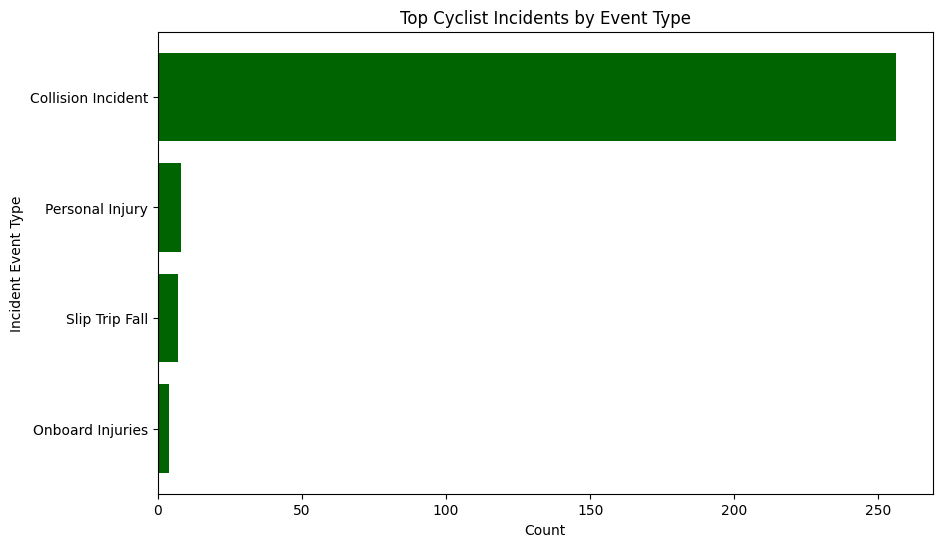

In [ ]:
# conversão para Pandas do df_9_2_pandas
df_10_pandas = df_10.toPandas()

# Ordenar os dados pelo número de ocorrências em ordem decrescente
df_10_pandas = df_10_pandas.sort_values(by='count', ascending=False)

# Plotar o gráfico funil
plt.figure(figsize=(10, 6))
plt.barh(df_10_pandas['Incident Event Type'], df_10_pandas['count'], color='darkgreen')
plt.xlabel('Count')
plt.ylabel('Incident Event Type')
plt.title('Top Cyclist Incidents by Event Type')
plt.gca().invert_yaxis()  # Inverter a ordem para que o maior valor fique no topo
plt.show()